sp500                  17836
cpi                       30
usd_eur                13570
usd_jpy                 6265
sp500_pct_change       17837
sp500_rollmean_5       17840
sp500_rollstd_5        17840
sp500_rollmean_20      17855
sp500_rollstd_20       17855
cpi_pct_change            31
cpi_rollmean_5            34
cpi_rollstd_5             34
cpi_rollmean_20           49
cpi_rollstd_20            49
usd_eur_pct_change     13571
usd_eur_rollmean_5     13574
usd_eur_rollstd_5      13574
usd_eur_rollmean_20    13589
usd_eur_rollstd_20     13589
usd_jpy_pct_change      6266
usd_jpy_rollmean_5      6269
usd_jpy_rollstd_5       6269
usd_jpy_rollmean_20     6284
usd_jpy_rollstd_20      6284
dtype: int64
Test MSE: 0.000047
Test R²: 0.2530
Top coefficients by magnitude:
cpi_pct_change         0.738074
usd_jpy_pct_change     0.480958
usd_eur_rollmean_5     0.389105
usd_eur               -0.346060
usd_eur_pct_change     0.309799
usd_eur_rollmean_20   -0.048013
usd_eur_rollstd_20     0.013035
u

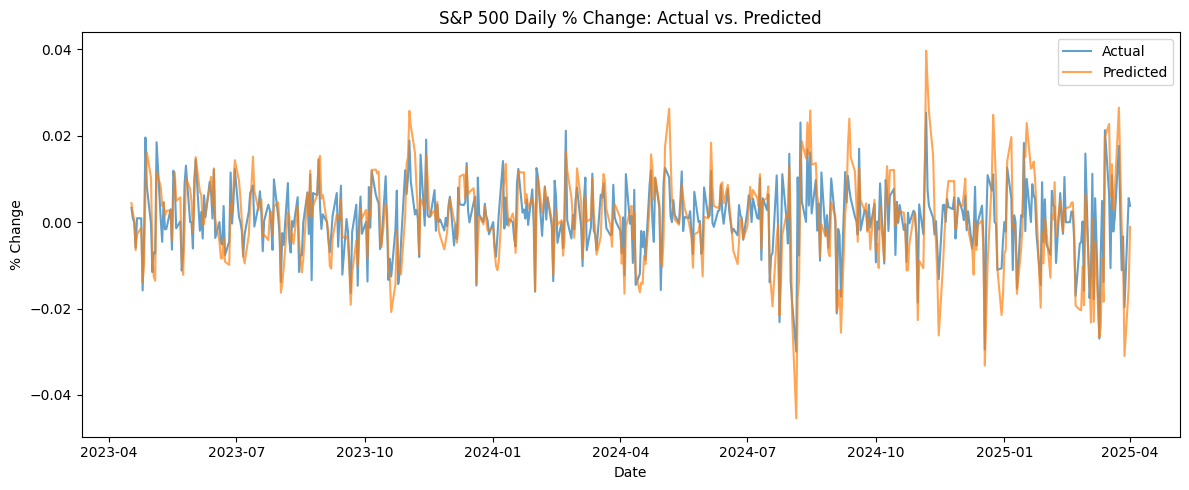

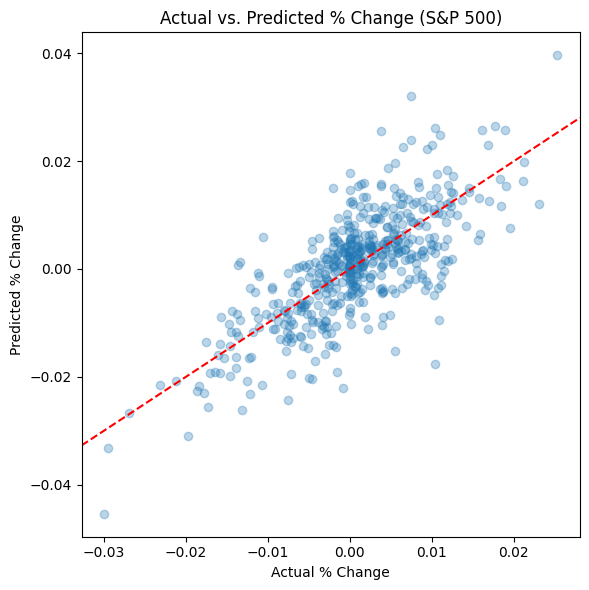

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
# Add the project root to the Python path
sys.path.append(os.path.abspath(".."))

from src.utils.preprocess import (
    load_series_from_csv,
    preprocess_series,
    merge_series_dict,
    add_derived_features,
    train_test_split_time_series
)

series_dict = {
    "sp500": preprocess_series(load_series_from_csv("sp500.csv")),
    "cpi": preprocess_series(load_series_from_csv("cpi.csv")),
    "usd_eur": preprocess_series(load_series_from_csv("usd_eur.csv")),
    "usd_jpy": preprocess_series(load_series_from_csv("usd_jpy.csv")),
}
df = merge_series_dict(series_dict)
# print(df.head())


df_with_features = add_derived_features(df)
# Optionally inspect how much data survives
print(df_with_features.isna().sum())
# Drop all rows that have NaNs *once only* here
df_with_features = df_with_features.dropna()
# print(df_with_features.columns)
# print(df_with_features.dropna().head())

# Split first
train_df, test_df = train_test_split_time_series(df_with_features)
# print(f"Train: {train_df.index.min()} to {train_df.index.max()}")
# print(f"Test:  {test_df.index.min()} to {test_df.index.max()}")
# print(len(train_df))
# print(len(test_df))

from src.models.regression import train_linear_model, evaluate_model

# Drop target from features
target = "sp500_pct_change"
features = [col for col in train_df.columns if col != target]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

model = train_linear_model(X_train, y_train)
mse, r2, y_pred = evaluate_model(model, X_test, y_test)

print(f"Test MSE: {mse:.6f}")
print(f"Test R²: {r2:.4f}")

# Show feature importances
coefs = pd.Series(model.coef_, index=features).sort_values(key=abs, ascending=False)

print("Top coefficients by magnitude:")
print(coefs.head(10))


plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Actual", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted", alpha=0.7)
plt.title("S&P 500 Daily % Change: Actual vs. Predicted")
plt.xlabel("Date")
plt.ylabel("% Change")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual % Change")
plt.ylabel("Predicted % Change")
plt.title("Actual vs. Predicted % Change (S&P 500)")
plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.tight_layout()
plt.show()
